In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns 
from pandas.plotting import register_matplotlib_converters 
from statsmodels.tsa.seasonal import STL

In [3]:
path = "household_power_consumption.txt"
df = pd.read_csv(path,delimiter=";",dtype="str")

#Combine date and time
df["datetime"] = pd.to_datetime(df["Date"]+" "+df["Time"])
#Convert other columns to numeric
df["Global_active_power"] = pd.to_numeric(df["Global_active_power"],errors="coerce")
df["Global_reactive_power"] = pd.to_numeric(df["Global_reactive_power"],errors="coerce")
df["Voltage"] = pd.to_numeric(df["Voltage"],errors="coerce")
df["Global_intensity"] = pd.to_numeric(df["Global_intensity"],errors="coerce")
df["Sub_metering_1"] = pd.to_numeric(df["Sub_metering_1"],errors="coerce")
df["Sub_metering_2"] = pd.to_numeric(df["Sub_metering_2"],errors="coerce")
df["Sub_metering_3"] = pd.to_numeric(df["Sub_metering_3"],errors="coerce")

#Timestamp rounded to floor hour
df["timestamp"] = df["datetime"].dt.floor("h")

# Interpolate missing values for short gaps up to 60 minutes
numeric_cols = df.select_dtypes(include=["number"]).columns
df.set_index("datetime",inplace=True)
df[numeric_cols] = df[numeric_cols].interpolate(method="time", limit=60)

df.head()

C:\Users\valta\AppData\Local\Temp\ipykernel_14800\4165190083.py:5: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["datetime"] = pd.to_datetime(df["Date"]+" "+df["Time"])


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,timestamp
datetime,,,,,,,,,,
2006-12-16 17:24:00,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,2006-12-16 17:00:00
2006-12-16 17:25:00,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,2006-12-16 17:00:00
2006-12-16 17:26:00,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,2006-12-16 17:00:00
2006-12-16 17:27:00,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,2006-12-16 17:00:00
2006-12-16 17:28:00,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,2006-12-16 17:00:00


In [4]:
# Resample to hourly data by taking mean of each hour
df_hourly = df.resample("h").agg({
    "Global_active_power": "mean",
    "Global_reactive_power": "mean",
    "Global_intensity": "mean",
    "Voltage": "mean",
    "Global_intensity": "mean",
    "Sub_metering_1": "mean",
    "Sub_metering_2": "mean",
    "Sub_metering_3": "mean"
})

df_hourly

,Global_active_power,Global_reactive_power,Global_intensity,Voltage,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,18.100000,234.643889,0.0,0.527778,16.861111
2006-12-16 18:00:00,3.632200,0.080033,15.600000,234.580167,0.0,6.716667,16.866667
2006-12-16 19:00:00,3.400233,0.085233,14.503333,233.232500,0.0,1.433333,16.683333
2006-12-16 20:00:00,3.268567,0.075100,13.916667,234.071500,0.0,0.000000,16.783333
2006-12-16 21:00:00,3.056467,0.076667,13.046667,237.158667,0.0,0.416667,17.216667
...,...,...,...,...,...,...,...
2010-11-26 17:00:00,1.725900,0.061400,7.216667,237.069667,0.0,0.000000,12.866667
2010-11-26 18:00:00,1.573467,0.053700,6.620000,237.531833,0.0,0.000000,0.000000
2010-11-26 19:00:00,1.659333,0.060033,7.056667,236.741000,0.0,0.066667,0.000000


In [5]:
# Fill remaining missing values using weekly seasonality
df_hourly = df_hourly.fillna(df_hourly.shift(freq="168h"))
df_hourly
isna_counts = df_hourly.isna().sum()
print(isna_counts)
df_hourly

Global_active_power      0
Global_reactive_power    0
Global_intensity         0
Voltage                  0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64


,Global_active_power,Global_reactive_power,Global_intensity,Voltage,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,18.100000,234.643889,0.0,0.527778,16.861111
2006-12-16 18:00:00,3.632200,0.080033,15.600000,234.580167,0.0,6.716667,16.866667
2006-12-16 19:00:00,3.400233,0.085233,14.503333,233.232500,0.0,1.433333,16.683333
2006-12-16 20:00:00,3.268567,0.075100,13.916667,234.071500,0.0,0.000000,16.783333
2006-12-16 21:00:00,3.056467,0.076667,13.046667,237.158667,0.0,0.416667,17.216667
...,...,...,...,...,...,...,...
2010-11-26 17:00:00,1.725900,0.061400,7.216667,237.069667,0.0,0.000000,12.866667
2010-11-26 18:00:00,1.573467,0.053700,6.620000,237.531833,0.0,0.000000,0.000000
2010-11-26 19:00:00,1.659333,0.060033,7.056667,236.741000,0.0,0.066667,0.000000


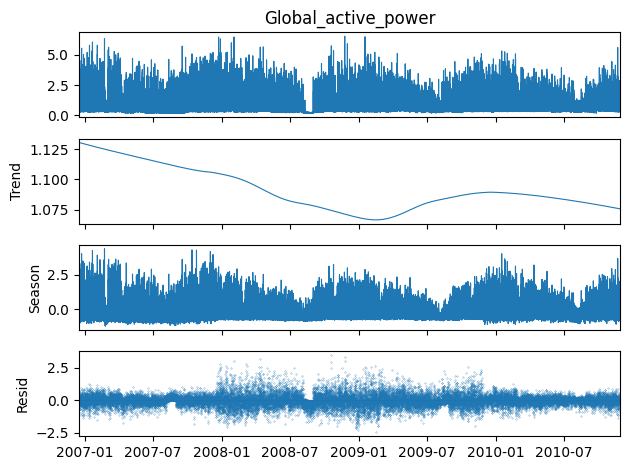

In [ ]:
y = df["Global_active_power"].resample("h").mean().interpolate("time").dropna() 
# STL decomposition with yearly seasonality (24*365 hours)
stl = STL(y, period=24*365) 
res = stl.fit() 
fig = res.plot()
for ax in fig.axes:
    for line in ax.get_lines():
        line.set_linewidth(0.8)      # thinner lines
        line.set_markersize(0.2)       # smaller markers
plt.tight_layout()
plt.show()

In [20]:
# A column for month
df["month"] = df.index.month

# Define seasons
def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Autumn"

df["season"] = df["month"].apply(get_season)

# For each season, calculate mean Global_active_power
seasonal_means = df.groupby("season")["Global_active_power"].mean()
print(seasonal_means)


season
Autumn    1.134609
Spring    1.103055
Summer    0.726709
Winter    1.417706
Name: Global_active_power, dtype: float64


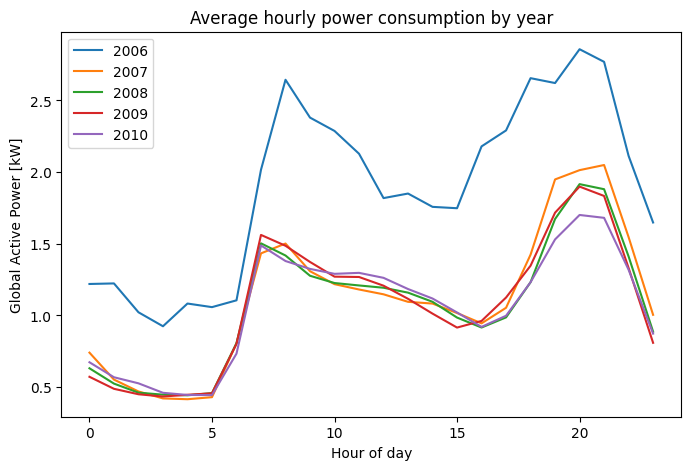

In [ ]:
# Only test plot
df["year"] = df.index.year
df["hour"] = df.index.hour

daily_pattern = df.groupby(["year", "hour"])["Global_active_power"].mean().reset_index()

plt.figure(figsize=(8,5))
for year in sorted(daily_pattern["year"].unique()):
    subset = daily_pattern[daily_pattern["year"] == year]
    plt.plot(subset["hour"], subset["Global_active_power"], label=str(year))
plt.legend()
plt.title("Average hourly power consumption by year")
plt.xlabel("Hour of day")
plt.ylabel("Global Active Power [kW]")
plt.show()


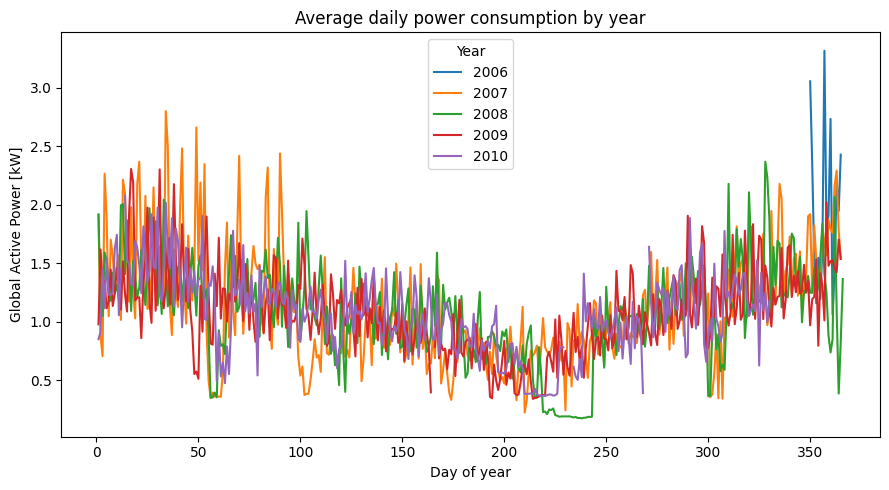

In [ ]:
df["year"] = df.index.year
df["day_of_year"] = df.index.dayofyear

# Average daily mean by year
daily_pattern = df.groupby(["year", "day_of_year"])["Global_active_power"].mean().reset_index()

plt.figure(figsize=(9,5))
for year in sorted(daily_pattern["year"].unique()):
    subset = daily_pattern[daily_pattern["year"] == year]
    plt.plot(subset["day_of_year"], subset["Global_active_power"], label=str(year))

plt.legend(title="Year")
plt.title("Average daily power consumption by year")
plt.xlabel("Day of year")
plt.ylabel("Global Active Power [kW]")
plt.tight_layout()
plt.show()


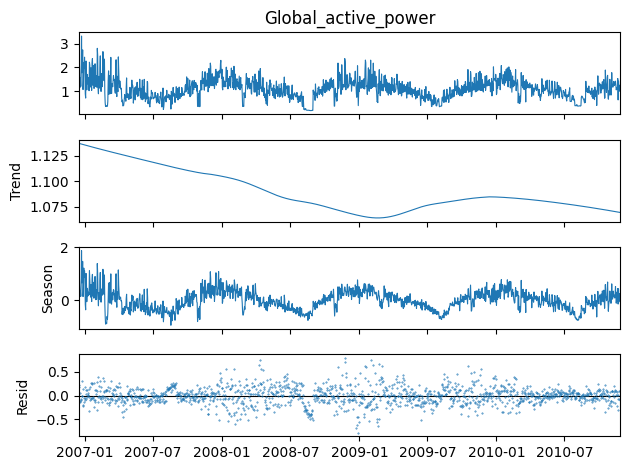

In [ ]:
# Annual seasonality example (daily data)
y_daily = df["Global_active_power"].resample("D").mean().interpolate("time")

stl = STL(y_daily, period=365)
res = stl.fit()

fig = res.plot()
for ax in fig.axes:
    for line in ax.get_lines():
        line.set_linewidth(0.8)      # thinner lines
        line.set_markersize(0.4)       # smaller markers
plt.tight_layout()
plt.show()
